# Sprint 1 — Case End Time Prediction

*The part of the tool that predicts how much time is left until the case of any given event finishes.*

## Table of contents
1. [Setup](#1-setup)
2. [Case end time prediction](#2-case-end-time-prediction)
3. [Complete CSV output](#3-complete-csv-output)
4. [Case end time prediction analysis](#4-case-end-time-prediction-analysis)  
    4.1 [Analysis with training data](#41-analysis-with-training-data)  
    4.2 [Analysis with testing data](#41-analysis-with-testing-data)

# 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

dt_format = '%Y/%m/%d %H:%M:%S.%f'

# Read TRAIN data and convert timestamps to datetime objects
df_train = pd.read_csv('../bpi_2012_train.csv', low_memory=False)
df_formatted = pd.to_datetime(df_train[['event time:timestamp', 'case REG_DATE']].stack(), format=dt_format, utc=True).unstack()
df_train['event time:timestamp'] = df_formatted['event time:timestamp']
df_train['case REG_DATE'] = df_formatted['case REG_DATE']


# Read TEST data and convert timestamps to datetime objects
df_test = pd.read_csv('../bpi_2012_test.csv', low_memory=False)
df_test_formatted = pd.to_datetime(df_test[['event time:timestamp', 'case REG_DATE']].stack(), format=dt_format, utc=True).unstack()
df_test['event time:timestamp'] = df_test_formatted['event time:timestamp']
df_test['case REG_DATE'] = df_test_formatted['case REG_DATE']

# 2. Case end time prediction
This section is for predicting how long a trace will take from a particular event type onwards to complete. It only uses the event type in the estimation.

The estimation is made as follows.

1. Group all events in the dataset by event type. For example, you'll have one group for "W_Nabellen offertes", one for "O_CREATED", etc.
2. For every event in these groups, check the time difference between this event and the end time of its trace.
3. Take the average of all of these time differences per group to find out how long it usually takes from that event type until the end of the case. This is considered the prediction.

> *Example*: After "W_Nabellen offertes" it takes on average 9087413 seconds for the case to end, so if an event is of type "W_Nabellen offertes", this model predicts 9087413 seconds until the trace ends.

In [2]:
# For every event in the list, find the final event in the its case and store it's time as the trace end time
df_train_grouped_sorted = df_train.sort_values('event time:timestamp').groupby('case concept:name')
df_train_trace_end = df_train_grouped_sorted.tail(1)[['case concept:name', 'event time:timestamp']]
df_train_trace_end = df_train_trace_end.rename(columns={"case concept:name": "case concept:name", "event time:timestamp": "trace_end"})

In [3]:
# Group events by event type
df_train_grouped_event = df_train.groupby('event concept:name')[['case concept:name', 'event concept:name', 'event time:timestamp']]
df_train_event_diffs = pd.DataFrame(columns=['type', 'prediction_time_trace_end'])

for name, group in df_train_grouped_event:
    # Merge the current group with the trace_end data
    merged = group.merge(df_train_trace_end, on="case concept:name", how="outer")
    
    # Create a new series indicating the difference between the end of the trace and the completion of the current event
    diff_series = merged['trace_end'] - merged['event time:timestamp']

    # Add the time difference to the dataframe in seconds
    merged['differential (s)'] = diff_series
    merged['differential (s)'] = merged['differential (s)'].apply(lambda x: x.total_seconds())

    # Add the average time until the end of the trace to the dataframe
    df_group_diff = pd.DataFrame([[name, round(merged['differential (s)'].mean())]], columns=['type', 'prediction_time_trace_end'])
    df_train_event_diffs = pd.concat([df_train_event_diffs, df_group_diff], ignore_index=True)

df_train_event_diffs

,type,prediction_time_trace_end
0,A_ACCEPTED,9406940
1,A_ACTIVATED,6694749
2,A_APPROVED,6694749
3,A_CANCELLED,5000249
4,A_DECLINED,898658
5,A_FINALIZED,9571417
6,A_PARTLYSUBMITTED,4444338
7,A_PREACCEPTED,7743210
8,A_REGISTERED,6694749
9,A_SUBMITTED,4444339


# 3. Complete CSV output
This cell produces the final output dataframe containing the predictions for both the test and training data, to be exported to CSV.

In [4]:
result_train = df_train.merge(df_train_event_diffs, left_on='event concept:name', right_on='type', how='left').drop(columns = ['type'])
result_test = df_test.merge(df_train_event_diffs, left_on='event concept:name', right_on='type', how='left').drop(columns = ['type'])

result_complete = pd.concat([result_train, result_test])
result_complete.head()

,Unnamed: 0,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,prediction_time_trace_end
0,0,0,173688,2011-09-30 22:38:44.546000+00:00,20000,A_SUBMITTED,COMPLETE,2011-01-10 01:38:44.546000+00:00,4444339
1,1,1,173688,2011-09-30 22:38:44.546000+00:00,20000,A_PARTLYSUBMITTED,COMPLETE,2011-01-10 01:38:44.880000+00:00,4444338
2,2,2,173688,2011-09-30 22:38:44.546000+00:00,20000,A_PREACCEPTED,COMPLETE,2011-01-10 01:39:37.906000+00:00,7743210
3,3,3,173688,2011-09-30 22:38:44.546000+00:00,20000,W_Completeren aanvraag,SCHEDULE,2011-01-10 01:39:38.875000+00:00,8116785
4,4,4294967296,173691,2011-10-01 06:08:58.256000+00:00,5000,A_SUBMITTED,COMPLETE,2011-01-10 09:08:58.256000+00:00,4444339


# 4. Case end time prediction analysis
## 4.1 Analysis with training data
This section is meant to check how good this estimation actually is. The first block analyzes the performance of the model on the training data (to check the variance).

Error percentage of full training dataset


,error_percentage
count,2.143770e+05
mean,4.058962e+07
std,1.600566e+08
min,-9.600000e+01
25%,-4.600000e+01
50%,2.700000e+02
75%,6.032500e+04
max,1.009877e+09


Error percentage capped at 5000, for plotting purposes


,error_percentage
count,146556.000000
mean,355.855571
std,818.506434
min,-96.000000
25%,-57.000000
50%,-9.000000
75%,306.000000
max,4999.000000


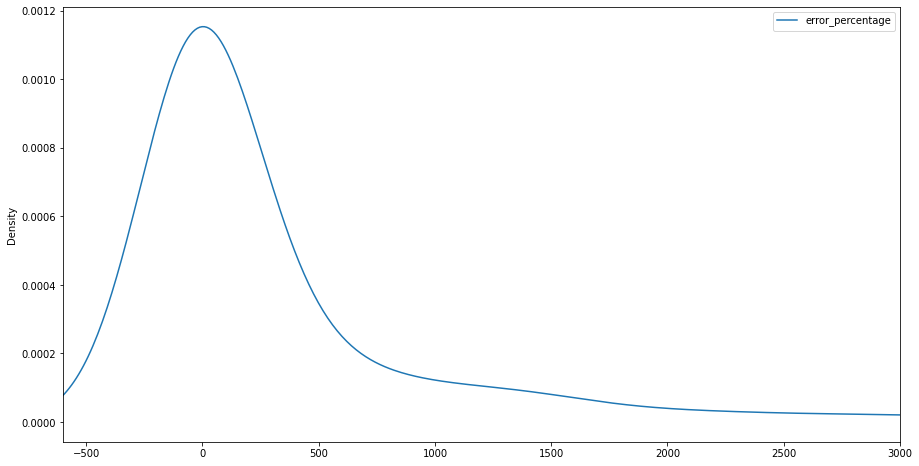

In [5]:
r_train_analysis = result_train.merge(df_train_trace_end, on='case concept:name', how='left')
diff_series = r_train_analysis['trace_end'] - r_train_analysis['event time:timestamp']

# Add the time difference to the dataframe in seconds
r_train_analysis['time_trace_end'] = diff_series.apply(lambda x: round(x.total_seconds()) if round(x.total_seconds()) != 0 else 1 )

r_train_analysis['error_percentage'] = round(((r_train_analysis['prediction_time_trace_end'] - r_train_analysis['time_trace_end']) / r_train_analysis['time_trace_end'] * 100).astype(int))
r_train_analysis.head(10)

# Select a subset with error percentage below 5000, for plotting purposes
r_train_analysis_plot = r_train_analysis[r_train_analysis['error_percentage'] < 5000]
ax = r_train_analysis_plot.plot.kde(y='error_percentage', use_index=True, figsize=(15, 8), bw_method=0.3)
ax.set_xlim(-600, 3000)
ax

print("Error percentage of full training dataset")
display(r_train_analysis[['error_percentage']].describe())
print("Error percentage capped at 5000, for plotting purposes")
r_train_analysis_plot[['error_percentage']].describe()

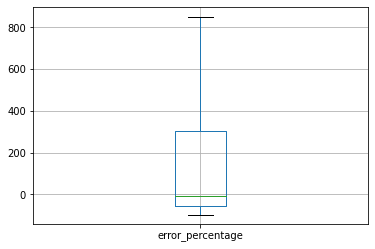

In [6]:
ax_bp = r_train_analysis_plot.boxplot(column='error_percentage', showfliers=False)

## 4.2 Analysis with testing data

In [7]:
# Generate case end time for training data
df_test_grouped_sorted = df_test.sort_values('event time:timestamp').groupby('case concept:name')
df_test_trace_end = df_test_grouped_sorted.tail(1)[['case concept:name', 'event time:timestamp']]
df_test_trace_end = df_test_trace_end.rename(columns={"case concept:name": "case concept:name", "event time:timestamp": "trace_end"})

Error percentage of full testing dataset


,error_percentage
count,4.782300e+04
mean,4.356366e+07
std,1.678967e+08
min,-9.600000e+01
25%,-4.400000e+01
50%,8.300000e+01
75%,1.313110e+05
max,1.009877e+09


Error percentage capped at 5000, for plotting purposes


,error_percentage
count,31720.000000
mean,261.547415
std,755.020081
min,-96.000000
25%,-56.000000
50%,-30.000000
75%,73.000000
max,4992.000000


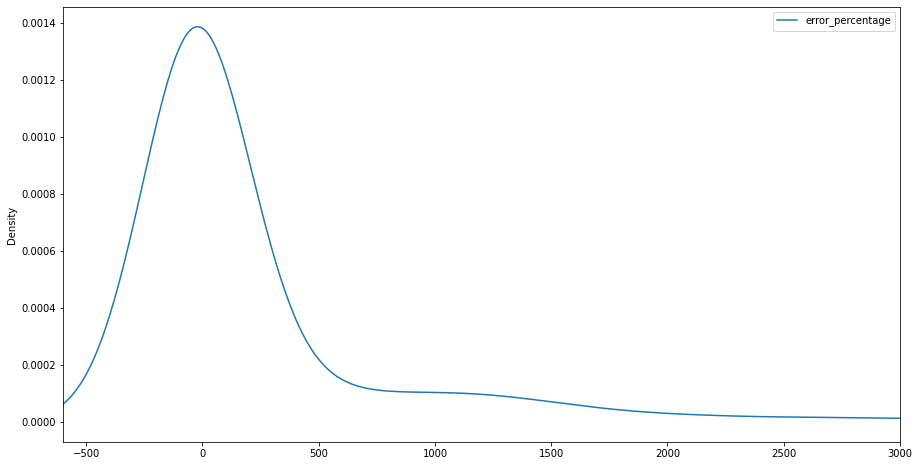

In [8]:
r_test_analysis = result_test.merge(df_test_trace_end, on='case concept:name', how='left')
diff_series = r_test_analysis['trace_end'] - r_test_analysis['event time:timestamp']

# Add the time difference to the dataframe in seconds
r_test_analysis['time_trace_end'] = diff_series.apply(lambda x: round(x.total_seconds()) if round(x.total_seconds()) != 0 else 1 )

r_test_analysis['error_percentage'] = round(((r_test_analysis['prediction_time_trace_end'] - r_test_analysis['time_trace_end']) / r_test_analysis['time_trace_end'] * 100).astype(int))
r_test_analysis.head(10)

# Select a subset with error percentage below 5000, for plotting purposes
r_test_analysis_plot = r_test_analysis[r_test_analysis['error_percentage'] < 5000]
ax = r_test_analysis_plot.plot.kde(y='error_percentage', use_index=True, figsize=(15, 8), bw_method=0.3)
ax.set_xlim(-600, 3000)
ax

print("Error percentage of full testing dataset")
display(r_test_analysis[['error_percentage']].describe())
print("Error percentage capped at 5000, for plotting purposes")
r_test_analysis_plot[['error_percentage']].describe()

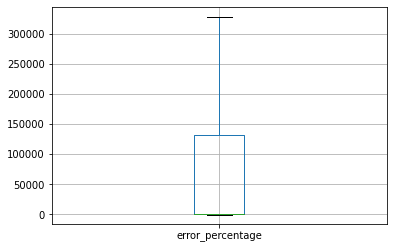

In [9]:
ax_bp = r_test_analysis.boxplot(column='error_percentage', showfliers=False)

## 4.3 Analysis conclusion
This "naïve" or "baseline" prediction is not too great. The error percentage without outliers, of which the distribution is shown in the boxplot above, indicates that the baseline is commonly off, and tends to overestimate the completion time of the case. The biggest problem is that there are some insane outliers, the worst having an error percentage of around *1.000.000.000%* in both the training and testing dataset.